In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import svd, qr, norm
from scipy.linalg import solve
from sklearn.metrics import mean_squared_error
import scipy.linalg as las
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [38]:
trainData = pd.read_csv('data/DailyDelhiClimateTrain.csv')
testData = pd.read_csv('data/DailyDelhiClimateTest.csv')

print("Dati di Training: ")
print(trainData)
print("Dati di Test: ")
print(testData)

Dati di Training: 
            date   meantemp    humidity  wind_speed  meanpressure
0     2013-01-01  10.000000   84.500000    0.000000   1015.666667
1     2013-01-02   7.400000   92.000000    2.980000   1017.800000
2     2013-01-03   7.166667   87.000000    4.633333   1018.666667
3     2013-01-04   8.666667   71.333333    1.233333   1017.166667
4     2013-01-05   6.000000   86.833333    3.700000   1016.500000
...          ...        ...         ...         ...           ...
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 5 columns]
Dati di Test: 
           date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.5

In [39]:
# Risolviamo il problema ai minimi quadrati calcolando la fattorizzazione QR
# il dato di input mode="economic" calcola solo le prime colonne di Q
def lss_thin_qr(A, b):
  (Q, R) = las.qr(A, mode='economic')
  cond_thin_qr = np.linalg.cond(R)
  soluzioni = las.solve(R, (Q.T @ b))
  return soluzioni, cond_thin_qr

In [40]:
def lss_pivoting_qr(A, b):
  (Q,R,Pe) = las.qr(A,mode="economic",pivoting='True')
  cond_pivoting_qr = np.linalg.cond(R)
  #print(Pe)
  nrd = A.shape[1] # prendo il numero di colonne
  soluzioni=las.solve(R[0:nrd, 0:nrd], np.dot(np.transpose(Q[:, 0:nrd]), b))
  soluzioni=las.solve(R, np.dot(np.transpose(Q), b))
  return soluzioni, Pe, cond_pivoting_qr # restituisco anche il vettore di permutazione,
                                         # che servirà nella predizione

In [41]:
def lss_normali(A, b):
  ATA = np.dot(A.T, A)
  cond_normali = np.linalg.cond(ATA)
  soluzioni = las.solve(ATA, (A.T @ b))
  return soluzioni, cond_normali

In [42]:
class PCR:
    def __init__(self, A, b):
        self.A = A
        U, s, Vt = np.linalg.svd(A, full_matrices=True)
        self.U = U
        self.s = s
        self.Vt = Vt
        self.b = b

    def _seleziona_k_componenti(self, k):
        U_k = self.U[:, :k]
        s_k = self.s[:k]
        Vt_k = self.Vt[:k, :]
        return U_k, s_k, Vt_k

    def _risolvi(self, U_k, s_k, V_k):
        return np.dot(V_k.T, (np.dot(self.b.T, U_k) / s_k).T)

    def _getCondizionamento(self, s_k):
        #print(s_k)
        return s_k[0] / s_k[-1]

    def Scree_Plot_Cattel_Mostra_Plot(self):
        plt.figure()
        range_sing_vals = np.arange(len(self.s)) + 1
        plt.semilogy(range_sing_vals, self.s, 'ro-', linewidth=2)
        plt.title('Scree Plot')
        plt.xlabel('Componenti Principali')
        plt.ylabel('Valori Singolari')
        plt.show()

    def Scree_Plot_Cattel_Seleziona_k(self):
        k = int(input('Inserisci il numero di componenti principali da mantenere: '))

        start_time = time.time()

        U_k, s_k, Vt_k = self._seleziona_k_componenti(k)
        condizionamento = self._getCondizionamento(s_k)
        soluzioni = self._risolvi(U_k, s_k, Vt_k)

        end_time = time.time()

        tempo = end_time - start_time
        return soluzioni, tempo, condizionamento


    def Guttman_Keiser(self, soglia):
        k = len(self.s[self.s > soglia])
        #print("k scelto da guttman keiser: ", k)
        U_k, s_k, Vt_k = self._seleziona_k_componenti(k)
        condizionamento = self._getCondizionamento(s_k)
        soluzioni = self._risolvi(U_k, s_k, Vt_k)
        return soluzioni, k, condizionamento

    def criterio_Energia(self, energia):
        energia_totale = np.sum(self.s ** 2)
        percentuale = energia_totale * energia / 100

        # Determino il numero minimo di componenti principali per conservare una certa percentuale di energia
        temp = self.s[0] ** 2
        i = 1
        while temp < percentuale and i < len(self.s):
            i += 1
            temp = np.sum(self.s[:i + 1] ** 2)

        # Seleziono i primi k componenti principali
        #print("k selezionato energia: ", i)
        U_k, s_k, Vt_k = self._seleziona_k_componenti(i)
        condizionamento = self._getCondizionamento(s_k)
        soluzioni = self._risolvi(U_k, s_k, Vt_k)
        return soluzioni, condizionamento

    def criterio_Entropia(self, percentuale):
        r = np.linalg.matrix_rank(self.A)
        #print("Valori singolari: ")
        #print(self.s)
        #print("rango: ", r)
        fj = self.s ** 2 / np.sum(self.s ** 2)
        #print("Fj: ", fj)
        E = -1 / np.log(r) * np.sum(fj * np.log(fj))
        #print('Entropia ', E)
        # Calcolo la somma cumulativa delle frazioni di energia
        F = np.cumsum(fj)
        # Trovo i valori dove la somma cumulativa supera l'entropia
        K = F > E
        #print(K)
        b = np.argmax(K)

        ks = int(np.ceil(r * E * percentuale))

        #print('Entropia =', E, ' k selezionato =', ks)

        U_k, s_k, Vt_k = self._seleziona_k_componenti(ks)
        condizionamento = self._getCondizionamento(s_k)
        soluzioni = self._risolvi(U_k, s_k, Vt_k)
        return soluzioni, condizionamento

In [43]:
class Swarm:
    # MSE è la nostra funzione obiettivo
    # essendo convessa è garantito trovare il minimo
    @staticmethod
    def funzione_obiettivo(X, y, theta):
        predizioni = np.dot(X, theta)
        return mean_squared_error(y, predizioni)

    @staticmethod
    def diameter(up, low):
        return np.linalg.norm(up - low)

    # PSO a D dimensioni
    @staticmethod
    def min_swarmND(N, x, pb, v, f, up, low, X, y, tol=1e-3, c1=0.5, c2=0.3, maxit=10):
        """
        INPUT:
        - N: dimensione dello swarm
        - x: vettore delle posizioni iniziali per ciascuna particella
        - pb: vettore delle posizioni personali migliori
        - v: vettore delle velocità per ciascuna particella
        - f: funzione obiettivo
        - up: confine superiore
        - low: confine inferiore
        - tol: threshold di accuratezza
        - c1, c2: parametri di apprendimento
        - maxit: numero massimo di iterazioni
        - X: Dati di input
        - y: Dati di output
        """
        iters = []
        nit = 0
        # deduzione della dimensione dello spazio
        D = x.shape[0]

        # inizializzazione
        # Calcola la funzione obiettivo per ciascuna particella
        # Trova l'indice della particella con il valore minimo della funzione obiettivo
        # Seleziona la particella con il miglior valore della funzione obiettivo
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])] # il range è nel numero di colonne di pb
        x_prec = np.copy(x)
        v_prec = np.copy(v)
        pb_prec = np.copy(pb)
        iters.append(x_prec)

        # calcolo di v in t+1 con strategia "global best"
        v = v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (gb.reshape((D, 1)) - x_prec)
        x = x_prec + v

        # controllo sulle particelle che escono dallo spazio di ricerca
        if np.min(x) < low:
            x[x < low] = low
        if np.max(x) > up:
            x[x > up] = up
        iters.append(x)

        # aggiornamento di x e pb
        ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
        pb[:, ind] = x[:, ind]
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

        # calcolo del raggio
        radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]), np.array([low, low]))

        while radius > tol and nit < maxit:
            x_prec = x
            v_prec = v
            pb_prec = pb

            v = v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (gb.reshape((D, 1)) - x_prec)
            x = x_prec + v

            if np.min(x) < low:
                x[x < low] = low
            if np.max(x) > up:
                x[x > up] = up
            iters.append(x)

            ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
            pb[:, ind] = x[:, ind]
            gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

            radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]), np.array([low, low]))
            nit += 1
        return x, v, pb, gb, nit, radius, iters


    def min_swarmND_Aggiustamento_Randomico(N, x, pb, v, f, up, low, X, y, tol=1e-3, c1=0.5, c2=0.3, maxit=10):
        """
                INPUT:
                - N: dimensione dello swarm
                - x: vettore delle posizioni iniziali per ciascuna particella
                - pb: vettore delle posizioni personali migliori
                - v: vettore delle velocità per ciascuna particella
                - f: funzione obiettivo
                - up: confine superiore
                - low: confine inferiore
                - tol: threshold di accuratezza
                - c1, c2: parametri di apprendimento
                - maxit: numero massimo di iterazioni
                - X: Dati di input
                - y: Dati di output
                """
        iters = []
        nit = 0
        # deduzione della dimensione dello spazio
        D = x.shape[0]

        # inizializzazione
        # Calcola la funzione obiettivo per ciascuna particella
        # Trova l'indice della particella con il valore minimo della funzione obiettivo
        # Seleziona la particella con il miglior valore della funzione obiettivo
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]  # il range è nel numero di colonne di pb
        x_prec = np.copy(x)
        v_prec = np.copy(v)
        pb_prec = np.copy(pb)
        iters.append(x_prec)

        # calcolo di v in t+1 con strategia "global best"

        mu = 0.72
        sigma = 0.1
        w = np.random.normal(mu, sigma)



        v = w * v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (
                    gb.reshape((D, 1)) - x_prec)
        x = x_prec + v

        # controllo sulle particelle che escono dallo spazio di ricerca
        if np.min(x) < low:
            x[x < low] = low
        if np.max(x) > up:
            x[x > up] = up
        iters.append(x)

        # aggiornamento di x e pb
        ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
        pb[:, ind] = x[:, ind]
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

        # calcolo del raggio
        radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]),
                                                                                 np.array([low, low]))

        while radius > tol and nit < maxit:
            x_prec = x
            v_prec = v
            pb_prec = pb

            w = np.random.normal(mu, sigma)

            v = w * v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (
                        gb.reshape((D, 1)) - x_prec)
            x = x_prec + v

            if np.min(x) < low:
                x[x < low] = low
            if np.max(x) > up:
                x[x > up] = up
            iters.append(x)

            ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
            pb[:, ind] = x[:, ind]
            gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

            radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]),
                                                                                     np.array([low, low]))
            nit += 1
        return x, v, pb, gb, nit, radius, iters


    def min_swarmND_Aggiustamento_Decremento_Lineare(N, x, pb, v, f, up, low, X, y, tol=1e-3, c1=0.5, c2=0.3, maxit=10):
        """
                INPUT:
                - N: dimensione dello swarm
                - x: vettore delle posizioni iniziali per ciascuna particella
                - pb: vettore delle posizioni personali migliori
                - v: vettore delle velocità per ciascuna particella
                - f: funzione obiettivo
                - up: confine superiore
                - low: confine inferiore
                - tol: threshold di accuratezza
                - c1, c2: parametri di apprendimento
                - maxit: numero massimo di iterazioni
                - X: Dati di input
                - y: Dati di output
                """
        iters = []
        nit = 0
        # deduzione della dimensione dello spazio
        D = x.shape[0]

        # inizializzazione
        # Calcola la funzione obiettivo per ciascuna particella
        # Trova l'indice della particella con il valore minimo della funzione obiettivo
        # Seleziona la particella con il miglior valore della funzione obiettivo
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]  # il range è nel numero di colonne di pb
        x_prec = np.copy(x)
        v_prec = np.copy(v)
        pb_prec = np.copy(pb)
        iters.append(x_prec)

        # calcolo di v in t+1 con strategia "global best"

        w_0 = 0.9
        w_nt = 0.4

        #Decremento lineare
        w = (w_0 - w_nt) * (maxit - nit) / (maxit) + w_nt



        v = w * v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (
                    gb.reshape((D, 1)) - x_prec)
        x = x_prec + v

        # controllo sulle particelle che escono dallo spazio di ricerca
        if np.min(x) < low:
            x[x < low] = low
        if np.max(x) > up:
            x[x > up] = up
        iters.append(x)

        # aggiornamento di x e pb
        ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
        pb[:, ind] = x[:, ind]
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

        # calcolo del raggio
        radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]),
                                                                                 np.array([low, low]))

        while radius > tol and nit < maxit:
            x_prec = x
            v_prec = v
            pb_prec = pb

            w_0 = 0.9
            w_nt = 0.4

            # Decremento lineare
            w = (w_0 - w_nt) * (maxit - nit) / (maxit) + w_nt

            v = w * v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (
                        gb.reshape((D, 1)) - x_prec)
            x = x_prec + v

            if np.min(x) < low:
                x[x < low] = low
            if np.max(x) > up:
                x[x > up] = up
            iters.append(x)

            ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
            pb[:, ind] = x[:, ind]
            gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

            radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]),
                                                                                     np.array([low, low]))
            nit += 1
        return x, v, pb, gb, nit, radius, iters


    def min_swarmND_Aggiustamento_Decremento_Non_Lineare(N, x, pb, v, f, up, low, X, y, tol=1e-3, c1=0.5, c2=0.3, maxit=10):
        """
                INPUT:
                - N: dimensione dello swarm
                - x: vettore delle posizioni iniziali per ciascuna particella
                - pb: vettore delle posizioni personali migliori
                - v: vettore delle velocità per ciascuna particella
                - f: funzione obiettivo
                - up: confine superiore
                - low: confine inferiore
                - tol: threshold di accuratezza
                - c1, c2: parametri di apprendimento
                - maxit: numero massimo di iterazioni
                - X: Dati di input
                - y: Dati di output
                """
        iters = []
        nit = 0
        # deduzione della dimensione dello spazio
        D = x.shape[0]

        # inizializzazione
        # Calcola la funzione obiettivo per ciascuna particella
        # Trova l'indice della particella con il valore minimo della funzione obiettivo
        # Seleziona la particella con il miglior valore della funzione obiettivo
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]  # il range è nel numero di colonne di pb
        x_prec = np.copy(x)
        v_prec = np.copy(v)
        pb_prec = np.copy(pb)
        iters.append(x_prec)

        # calcolo di v in t+1 con strategia "global best"
        #Inizializzo w a 0.9
        w = 0.9

        v = w * v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (
                    gb.reshape((D, 1)) - x_prec)
        x = x_prec + v

        # controllo sulle particelle che escono dallo spazio di ricerca
        if np.min(x) < low:
            x[x < low] = low
        if np.max(x) > up:
            x[x > up] = up
        iters.append(x)

        # aggiornamento di x e pb
        ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
        pb[:, ind] = x[:, ind]
        gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

        # calcolo del raggio
        radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]),
                                                                                 np.array([low, low]))

        while radius > tol and nit < maxit:
            x_prec = x
            v_prec = v
            pb_prec = pb

            # Decremento non lineare
            w = (w - 0.4) * (maxit - nit) / (maxit + 0.4)

            v = w * v_prec + c1 * np.random.rand(D, N) * (pb_prec - x_prec) + c2 * np.random.rand(D, N) * (
                        gb.reshape((D, 1)) - x_prec)
            x = x_prec + v

            if np.min(x) < low:
                x[x < low] = low
            if np.max(x) > up:
                x[x > up] = up
            iters.append(x)

            ind = np.argwhere([f(X, y, x[:, i]) < f(X, y, pb[:, i]) for i in range(pb.shape[1])]).flatten()
            pb[:, ind] = x[:, ind]
            gb = pb[:, np.argmin([f(X, y, pb[:, i]) for i in range(pb.shape[1])])]

            radius = np.max(np.linalg.norm(x - gb.reshape((D, 1)))) / Swarm.diameter(np.array([up, up]),
                                                                                     np.array([low, low]))
            nit += 1
        return x, v, pb, gb, nit, radius, iters

In [44]:
def normalizza_standard(X):
    scaler = StandardScaler()
    val = scaler.fit_transform(X)
    return val

In [45]:
def normalizza_minMax(X, min, Max):
    return (X - min) / (Max - min)

In [46]:
def RMSE(valore_esatto, predizione):
   return np.sqrt(mean_squared_error(valore_esatto, predizione))

In [47]:
class Modello:
  def _setVariabileTarget(self, idx_target):
    yTrain = self.trainData.iloc[:, idx_target].values
    yTest = self.testData.iloc[:, idx_target].values
    return yTrain, yTest

  def _normalizzaDati(self, XTrain, XTest):
    # Calcolo il minimo e il massimo dei dati di addestramento per le feature
    XMin = XTrain.min(axis=0)
    XMax = XTrain.max(axis=0)
    # Calcolo il minimo e il massimo dei dati di addestramento per il target
    yMin = self.yTrain.min()
    yMax = self.yTrain.max()

    # Normalizzo i dati di addestramento per le feature
    XTrainNorm = normalizza_minMax(XTrain, XMin, XMax)
    # Normalizzo i dati di test per le feature utilizzando il minimo e il massimo dei dati di addestramento
    XTestNorm = normalizza_minMax(XTest, XMin, XMax)

    # Normalizzo i dati di addestramento per il target
    yTrainNorm = normalizza_minMax(self.yTrain, yMin, yMax)
    # Normalizzo i dati di test per il target utilizzando il minimo e il massimo dei dati di addestramento
    yTestNorm = normalizza_minMax(self.yTest, yMin, yMax)

    return XTrainNorm, yTrainNorm, XTestNorm, yTestNorm

  def _getMatriceVandermonde(self, XTrain, XTest, dim1, dim2):
    # Aggiungo una colonna di 1 in XTrain
    XTrain = np.hstack([np.ones((dim1, 1)), XTrain])
    # Faccio lo stesso per il Test
    XTest = np.hstack([np.ones((dim2, 1)), XTest])

    return XTrain, XTest


  def _getFeature(self, dim1, dim2):
    yTrain = self.yTrain
    yTest = self.yTest

    match self.d:
      case 1:
        XTrain = np.arange(1, dim1 + 1).reshape(-1, 1)
        XTest = np.arange(dim1 + 1, dim1 + dim2 + 1).reshape(-1, 1)
        if self.isNormalizzato:
          XTrain, yTrain, XTest, yTest = self._normalizzaDati(XTrain, XTest)
        XTrain, XTest = self._getMatriceVandermonde(XTrain, XTest, dim1, dim2)
      case 2:
        XTrain1 = np.arange(1, dim1 + 1).reshape(-1, 1)
        XTrain2 = XTrain1 ** 2
        XTrain = np.hstack((XTrain1, XTrain2))

        XTest1 = np.arange(dim1 + 1, dim1 + dim2 + 1).reshape(-1, 1)
        XTest2 = XTest1 ** 2
        XTest = np.hstack((XTest1, XTest2))
        if self.isNormalizzato:
          XTrain, yTrain, XTest, yTest = self._normalizzaDati(XTrain, XTest)
        XTrain, XTest = self._getMatriceVandermonde(XTrain, XTest, dim1, dim2)
      case 3:
        XTrain1 = np.arange(1, dim1 + 1).reshape(-1, 1)
        XTrain2 = XTrain1 ** 2
        XTrain3 = XTrain1 ** 3
        XTrain = np.hstack((XTrain1, XTrain2, XTrain3))

        XTest1 = np.arange(dim1 + 1, dim1 + dim2 + 1).reshape(-1, 1)
        XTest2 = XTest1 ** 2
        XTest3 = XTest1 ** 3
        XTest = np.hstack((XTest1, XTest2, XTest3))
        if self.isNormalizzato:
          XTrain, yTrain, XTest, yTest = self._normalizzaDati(XTrain, XTest)
        XTrain, XTest = self._getMatriceVandermonde(XTrain, XTest, dim1, dim2)
      case 4:
        XTrain1 = np.arange(1, dim1 + 1).reshape(-1, 1)
        XTrain2 = XTrain1 ** 2
        XTrain3 = XTrain1 ** 3
        XTrain4 = XTrain1 ** 4
        XTrain = np.hstack((XTrain1, XTrain2, XTrain3, XTrain4))

        XTest1 = np.arange(dim1 + 1, dim1 + dim2 + 1).reshape(-1, 1)
        XTest2 = XTest1 ** 2
        XTest3 = XTest1 ** 3
        XTest4 = XTest1 ** 4
        XTest = np.hstack((XTest1, XTest2, XTest3, XTest4))
        if self.isNormalizzato:
          XTrain, yTrain, XTest, yTest = self._normalizzaDati(XTrain, XTest)
        XTrain, XTest = self._getMatriceVandermonde(XTrain, XTest, dim1, dim2)
      case _:
        print("d non specificata")
    return XTrain, yTrain, XTest, yTest


  def _get_parametri_PSO(self):
        # Parametri per PSO
        N = 30  # Numero di particelle
        D = self.XTrain.shape[1]  # Dimensione dello spazio dei parametri (numero di colonne di X)
        x = np.random.rand(D, N)  # Posizioni iniziali delle particelle
        v = np.random.rand(D, N)  # Velocità iniziali delle particelle
        pb = x  # Posizioni personali migliori iniziali (uguali alle posizioni iniziali)
        up = 10  # Limite superiore dei parametri
        low = -10  # Limite inferiore dei parametri
        tol = 1e-5  # Tolleranza per la convergenza
        c1 = 0.5  # Parametro di apprendimento c1
        c2 = 0.9  # Parametro di apprendimento c2
        maxit = 100  # Numero massimo di iterazioni

        # Funzione obiettivo
        f = lambda X, y, theta: Swarm.funzione_obiettivo(X, y, theta)

        return N, D, x, v, pb, up, low, tol, c1, c2, maxit, f


  def _getCoefficienti(self):
    pcr = PCR(self.XTrain, self.yTrain)
    PE = None
    N, D, posParticelle, v, pb, up, low, tol, c1, c2, maxit, f = self._get_parametri_PSO()
    match self.metodo:
      case 'normali':
        start = time.time()
        coeff, cond = lss_normali(self.XTrain, self.yTrain)
        tempo = time.time() - start
      case 'thin_qr':
        start = time.time()
        coeff, cond = lss_thin_qr(self.XTrain, self.yTrain)
        tempo = time.time() - start
      case 'thin_qr_pivoting':
        start = time.time()
        coeff, PE, cond = lss_pivoting_qr(self.XTrain, self.yTrain)
        tempo = time.time() - start
      case 'svd_scree_plot_cattel':
        pcr.Scree_Plot_Cattel_Mostra_Plot()
        print("\n\n") # colab si bugga con il plot e poi l'input
        coeff, tempo, cond = pcr.Scree_Plot_Cattel_Seleziona_k()
      case 'svd_guttman_keiser':
        start = time.time()
        coeff, k, cond = pcr.Guttman_Keiser(1)
        #print("k selezionato da Guttman-Keiser: ", k)
        tempo = time.time() - start
      case 'svd_energia':
        start = time.time()
        coeff, cond = pcr.criterio_Energia(90)
        tempo = time.time() - start
      case 'svd_entropia':
        start = time.time()
        coeff, cond = pcr.criterio_Entropia(0.95)
        tempo = time.time() - start
      case 'swarm':
        start = time.time()
        posParticelle, v, pb, coeff, nit, radius, iters = Swarm.min_swarmND(N, posParticelle, pb, v, f, up, low, self.XTrain, self.yTrain, tol, c1, c2, maxit)
        cond = np.linalg.cond(posParticelle)
        tempo = time.time() - start
      case 'swarm_rand':
        start = time.time()
        posParticelle, v, pb, coeff, nit, radius, iters = Swarm.min_swarmND_Aggiustamento_Randomico(N, posParticelle, pb, v, f, up, low, self.XTrain, self.yTrain, tol, c1, c2, maxit)
        cond = np.linalg.cond(posParticelle)
        tempo = time.time() - start
      case 'swarm_d_lineare':
        start = time.time()
        posParticelle, v, pb, coeff, nit, radius, iters = Swarm.min_swarmND_Aggiustamento_Decremento_Lineare(N, posParticelle, pb, v, f, up, low, self.XTrain, self.yTrain, tol, c1, c2, maxit)
        cond = np.linalg.cond(posParticelle)
        tempo = time.time() - start
      case 'swarm_d_non_lineare':
        start = time.time()
        posParticelle, v, pb, coeff, nit, radius, iters = Swarm.min_swarmND_Aggiustamento_Decremento_Non_Lineare(N, posParticelle, pb, v, f, up, low, self.XTrain, self.yTrain, tol, c1, c2, maxit)
        cond = np.linalg.cond(posParticelle)
        tempo = time.time() - start
    return coeff, cond, tempo, PE

  def _getPredizione(self, coeff, PE):
    # nel caso in cui ho un vettore di permutazione
    # avendo usato la qr
    if PE is not None:
      #print("permutazione: ", PE)
      nrd = self.XTest.shape[1]
      yPred = self.XTest[:, PE[0:nrd]] @ coeff
    else:
      yPred = self.XTest @ coeff

    return yPred


  def __init__(self, trainData, testData, metodo, target, isNormalizzato, d):
    self.metodo = metodo
    self.trainData = trainData
    self.testData = testData
    # Setto la variabile target a seconda di quella specificata
    match target:
      case 'meantemp':
        self.yTrain, self.yTest = self._setVariabileTarget(1)
      case 'humidity':
        self.yTrain, self.yTest = self._setVariabileTarget(2)
      case 'wind_speed':
        self.yTrain, self.yTest = self._setVariabileTarget(3)
      case 'mean_pressure':
        self.yTrain, self.yTest = self._setVariabileTarget(4)
      case _:
        print("Target non valida")

    self.isNormalizzato = isNormalizzato
    self.d = d

    # Entrambe le dimensioni servono per poter definire le feature
    # di input
    dim1 = self.yTrain.shape[0]
    dim2 = self.yTest.shape[0]

    # Ottengo tutte le feature necessarie per la costruzione del modell(o
    self.XTrain, self.yTrain, self.XTest, self.yTest = self._getFeature(dim1, dim2)

    # Ricavo i coefficienti per le predizioni
    # PE è il vettore di permutazione ovviamente se non viene utilizzata la qr
    # con pivoting sarà None
    coeff, self.condizionamento, self.tempo, PE = self._getCoefficienti()

    self.yPred = self._getPredizione(coeff, PE)

    self.rmse = RMSE(self.yTest, self.yPred)


In [48]:
def stampa_modelli(trainData, testData, target, isNormalizzato, d):
            x = Modello(trainData, testData, 'normali', target, isNormalizzato, d)
            y = Modello(trainData, testData, 'thin_qr', target, isNormalizzato, d)
            z = Modello(trainData, testData, 'thin_qr_pivoting', target, isNormalizzato, d)
            sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
            sgk = Modello(trainData, testData, 'svd_guttman_keiser', target, isNormalizzato, d)
            senrg = Modello(trainData, testData, 'svd_energia', target, isNormalizzato, d)
            sentr = Modello(trainData, testData, 'svd_entropia', target, isNormalizzato, d)
            swarm = Modello(trainData, testData, 'swarm', target, isNormalizzato, d)
            swarm_rand = Modello(trainData, testData, 'swarm_rand', target, isNormalizzato, d)
            swarm_d_lineare = Modello(trainData, testData, 'swarm_d_lineare', target, isNormalizzato, d)
            swarm_d_non_lineare = Modello(trainData, testData, 'swarm_d_non_lineare', target, isNormalizzato, d)


            print(f"Rango della matrice di Training: {np.linalg.matrix_rank(x.XTrain)}")
            print(f"\n\nRMSE Normali: {x.rmse:.4f}\t Tempo trascorso: {x.tempo:.4f}\tCondizionamento: {x.condizionamento:.4f}")
            print(f"RMSE THIN QR: {y.rmse:.4f}\t Tempo trascorso: {y.tempo:.4f}\tCondizionamento: {y.condizionamento:.4f}")
            print(f"RMSE THIN QR PIVOTING: {z.rmse:.4f}\t Tempo trascorso: {z.tempo:.4f}\tCondizionamento: {z.condizionamento:.4f}")
            print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")
            print(f"RMSE SVD GUTTMAN KEISER: {sgk.rmse:.4f}\t Tempo trascorso: {sgk.tempo:.4f}\tCondizionamento: {sgk.condizionamento:.4f}")
            print(f"RMSE SVD ENERGIA: {senrg.rmse:.4f}\t Tempo trascorso: {senrg.tempo:.4f}\tCondizionamento: {senrg.condizionamento:.4f}")
            print(f"RMSE SVD ENTROPIA: {sentr.rmse:.4f}\t Tempo trascorso: {sentr.tempo:.4f}\tCondizionamento: {sentr.condizionamento:.4f}\n")
            print(f'RMSE SWARM: {swarm.rmse:.4f}\t Tempo trascorso: {swarm.tempo:.4f}')
            print(f'RMSE SWARM RANDOM: {swarm_rand.rmse:.4f}\t Tempo trascorso: {swarm_rand.tempo:.4f}')
            print(f'RMSE SWARM DECREMENTO LINEARE: {swarm_d_lineare.rmse:.4f}\t Tempo trascorso: {swarm_d_lineare.tempo:.4f}')
            print(f'RMSE SWARM DECREMENTO NON LINEARE: {swarm_d_non_lineare.rmse:.4f}\t Tempo trascorso: {swarm_d_non_lineare.tempo:.4f}')

TARGET:  mean_pressure
Modello di regressione lineare: 

permutazione:  [1 0]


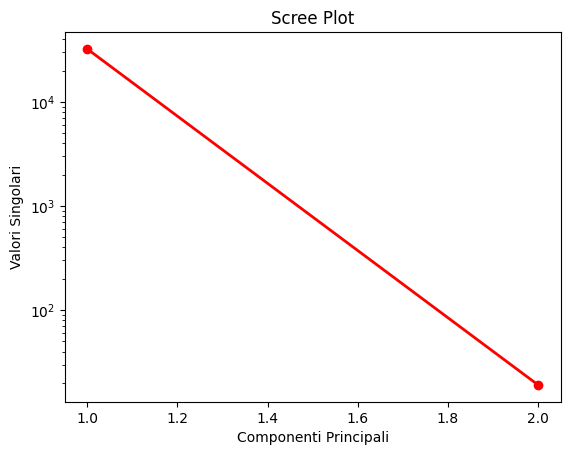




[3.22911408e+04 1.91082376e+01]
[3.22911408e+04 1.91082376e+01]
k selezionato energia:  1
[32291.14076454]
Valori singolari: 
[3.22911408e+04 1.91082376e+01]
rango:  2
Fj:  [9.99999650e-01 3.50166292e-07]
Entropia  8.014659060256458e-06
[ True  True]
Entropia = 8.014659060256458e-06  k selezionato = 1
[32291.14076454]
Rango della matrice di Training: 2


RMSE Normali: 89.8283	 Tempo trascorso: 0.0022	Condizionamento: 2855785.0123
RMSE THIN QR: 89.8283	 Tempo trascorso: 0.0008	Condizionamento: 1689.9068
RMSE THIN QR PIVOTING: 89.8283	 Tempo trascorso: 0.0006	Condizionamento: 1689.9068
RMSE SVD SCREE-PLOT CATTEL: 89.8283	 Tempo trascorso: 0.0013	Condizionamento: 1689.9068
RMSE SVD GUTTMAN KEISER: 89.8283	 Tempo trascorso: 0.0003	Condizionamento: 1689.9068
RMSE SVD ENERGIA: 581.2799	 Tempo trascorso: 0.0002	Condizionamento: 1.0000
RMSE SVD ENTROPIA: 581.2799	 Tempo trascorso: 0.0024	Condizionamento: 1.0000

RMSE SWARM: 586.5322	 Tempo trascorso: 1.0149
RMSE SWARM RANDOM: 575.7519	 Temp

In [15]:
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione lineare: \n")
d = 1
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  2
permutazione:  [2 1 0]


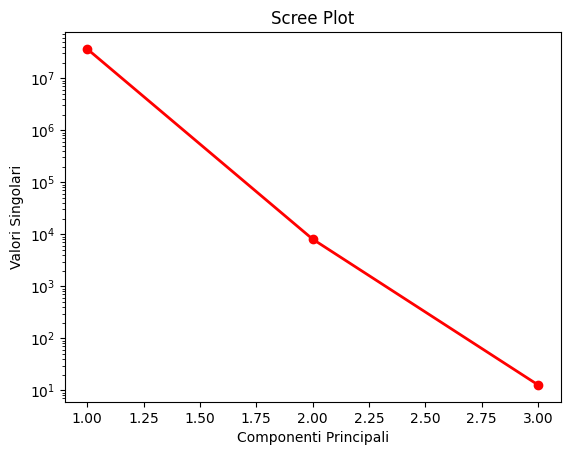




[3.65809314e+07 8.07280583e+03]
[3.65809314e+07 8.07280583e+03 1.27278904e+01]
k selezionato energia:  1
[36580931.37795942]
Valori singolari: 
[3.65809314e+07 8.07280583e+03 1.27278904e+01]
rango:  3
Fj:  [9.99999951e-01 4.87011790e-08 1.21060737e-13]
Entropia  7.907376046687522e-07
[ True  True  True]
Entropia = 7.907376046687522e-07  k selezionato = 1
[36580931.37795942]
Rango della matrice di Training: 3


RMSE Normali: 89.4861	 Tempo trascorso: 0.0007	Condizionamento: 8260316067790.5234
RMSE THIN QR: 89.4861	 Tempo trascorso: 0.0004	Condizionamento: 2874076.5598
RMSE THIN QR PIVOTING: 89.4861	 Tempo trascorso: 0.0004	Condizionamento: 2874076.5598
RMSE SVD SCREE-PLOT CATTEL: 452.7535	 Tempo trascorso: 0.0009	Condizionamento: 4531.3776
RMSE SVD GUTTMAN KEISER: 89.4861	 Tempo trascorso: 0.0004	Condizionamento: 2874076.5598
RMSE SVD ENERGIA: 826.9908	 Tempo trascorso: 0.0002	Condizionamento: 1.0000
RMSE SVD ENTROPIA: 826.9908	 Tempo trascorso: 0.0015	Condizionamento: 1.0000

RMSE S

In [16]:
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 2)
d = 2
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  3
permutazione:  [3 2 1 0]


/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.42032e-20): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))


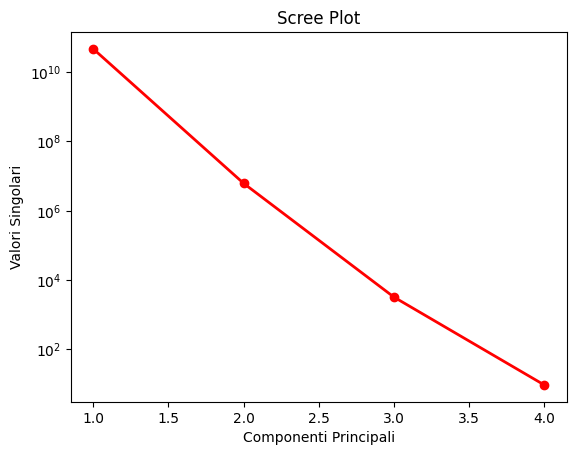




[4.52154130e+10 6.09682640e+06 3.22914578e+03]
[4.52154130e+10 6.09682640e+06 3.22914578e+03 9.53439356e+00]
k selezionato energia:  1
[4.5215413e+10]
Valori singolari: 
[4.52154130e+10 6.09682640e+06 3.22914578e+03 9.53439356e+00]
rango:  4
Fj:  [9.99999982e-01 1.81817066e-08 5.10037715e-15 4.44644718e-20]
Entropia  2.4686799354542904e-07
[ True  True  True  True]
Entropia = 2.4686799354542904e-07  k selezionato = 1
[4.5215413e+10]
Rango della matrice di Training: 4


RMSE Normali: 90.7305	 Tempo trascorso: 0.0032	Condizionamento: 22490142494780456960.0000
RMSE THIN QR: 90.7305	 Tempo trascorso: 0.0004	Condizionamento: 4742348081.2452
RMSE THIN QR PIVOTING: 90.7305	 Tempo trascorso: 0.0008	Condizionamento: 4742348080.3965
RMSE SVD SCREE-PLOT CATTEL: 433.6790	 Tempo trascorso: 0.0034	Condizionamento: 14002282.9854
RMSE SVD GUTTMAN KEISER: 90.7305	 Tempo trascorso: 0.0009	Condizionamento: 4742348081.2453
RMSE SVD ENERGIA: 997.6470	 Tempo trascorso: 0.0002	Condizionamento: 1.0000
RMSE

In [17]:
# SCELGO K = 3
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 3)
d = 3
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  3


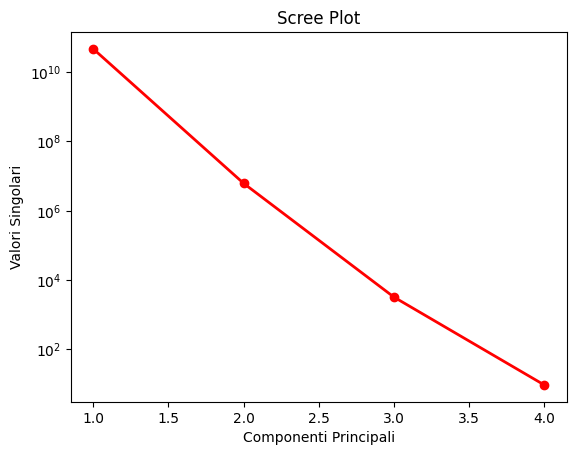




[4.5215413e+10 6.0968264e+06]
RMSE SVD SCREE-PLOT CATTEL: 790.3949	 Tempo trascorso: 0.0058	Condizionamento: 7416.2212


In [18]:
# SCELGO K = 2
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 3)
d = 3
sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  4
permutazione:  [4 3 2 1 0]


/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69015e-26): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))


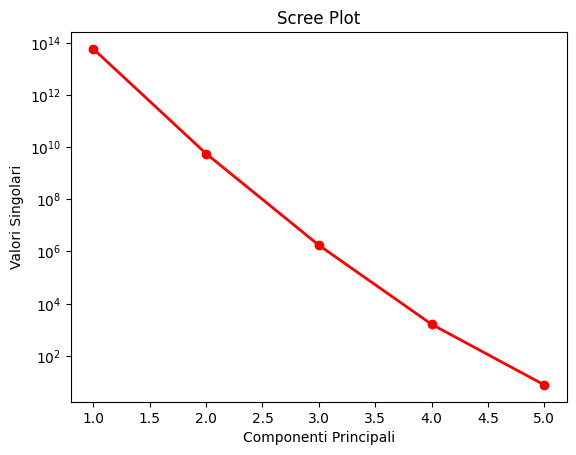




[5.83189916e+13 5.65192561e+09 1.74195409e+06 1.61460103e+03]
k scelto da guttman keiser:  5
[5.83189916e+13 5.65192561e+09 1.74195409e+06 1.61460103e+03
 7.61559166e+00]
k selezionato energia:  1
[5.83189916e+13]
Valori singolari: 
[5.83189916e+13 5.65192561e+09 1.74195409e+06 1.61460103e+03
 7.61559166e+00]
rango:  4
Fj:  [9.99999991e-01 9.39231954e-09 8.92181872e-16 7.66496954e-22
 1.70524696e-26]
Entropia  1.320023417142747e-07
[ True  True  True  True  True]
Entropia = 1.320023417142747e-07  k selezionato = 1
[5.83189916e+13]
Rango della matrice di Training: 4


RMSE Normali: 97.8711	 Tempo trascorso: 0.0009	Condizionamento: 52792673932931379167756288.0000
RMSE THIN QR: 97.8711	 Tempo trascorso: 0.0004	Condizionamento: 7657841198171.7930
RMSE THIN QR PIVOTING: 97.8711	 Tempo trascorso: 0.0005	Condizionamento: 7657829856730.1201
RMSE SVD SCREE-PLOT CATTEL: 522.6804	 Tempo trascorso: 0.0012	Condizionamento: 36119753800.8594
RMSE SVD GUTTMAN KEISER: 97.8731	 Tempo trascorso: 0.000

In [24]:
# QUI SCELGO K = 4
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 4)
d = 4
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  4


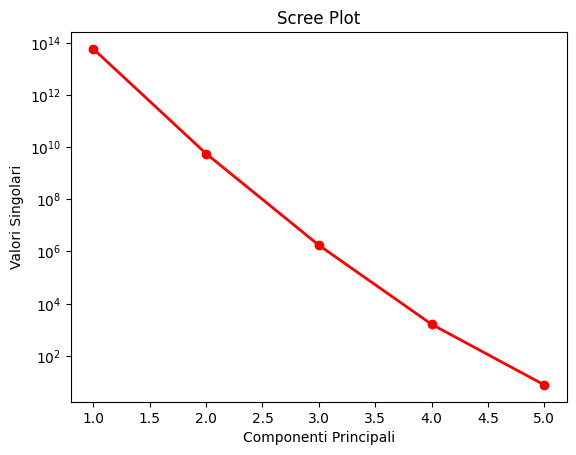




[5.83189916e+13 5.65192561e+09]
RMSE SVD SCREE-PLOT CATTEL: 1102.3002	 Tempo trascorso: 0.0021	Condizionamento: 10318.4287


In [25]:
# SCELGO K = 2
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 4)
d = 4
sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  4


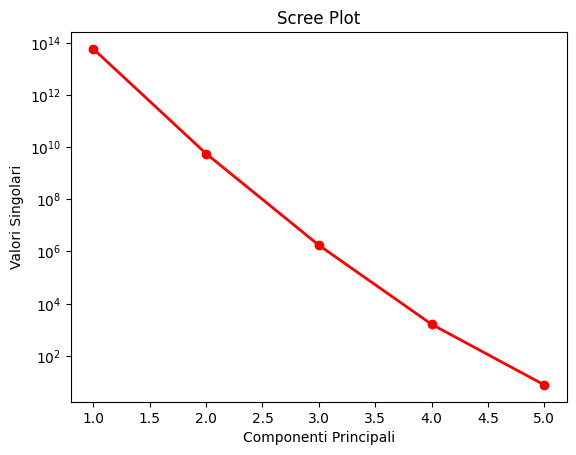




[5.83189916e+13 5.65192561e+09 1.74195409e+06]
RMSE SVD SCREE-PLOT CATTEL: 831.4798	 Tempo trascorso: 0.0023	Condizionamento: 33479063.4723


In [26]:
# SCELGO K = 3
isNormalizzato = False
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 4)
d = 4
sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")

TARGET:  mean_pressure
Modello di regressione lineare: 

permutazione:  [0 1]


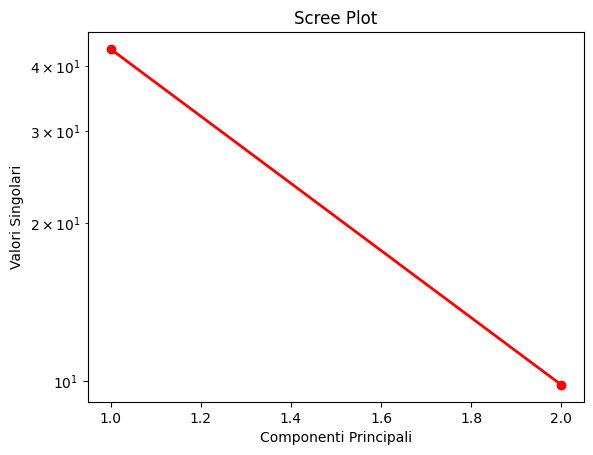




[43.04946532  9.81038481]
k scelto da guttman keiser:  2
[43.04946532  9.81038481]
k selezionato energia:  1
[43.04946532]
Valori singolari: 
[43.04946532  9.81038481]
rango:  2
Fj:  [0.95063163 0.04936837]
Entropia  0.2837077714812285
[ True  True]
Entropia = 0.2837077714812285  k selezionato = 1
[43.04946532]
Rango della matrice di Training: 2


RMSE Normali: 0.0117	 Tempo trascorso: 0.0006	Condizionamento: 19.2559
RMSE THIN QR: 0.0117	 Tempo trascorso: 0.0004	Condizionamento: 4.3882
RMSE THIN QR PIVOTING: 0.0117	 Tempo trascorso: 0.0003	Condizionamento: 4.3882
RMSE SVD SCREE-PLOT CATTEL: 0.0117	 Tempo trascorso: 0.0029	Condizionamento: 4.3882
RMSE SVD GUTTMAN KEISER: 0.0117	 Tempo trascorso: 0.0010	Condizionamento: 4.3882
RMSE SVD ENERGIA: 0.0309	 Tempo trascorso: 0.0002	Condizionamento: 1.0000
RMSE SVD ENTROPIA: 0.0309	 Tempo trascorso: 0.0004	Condizionamento: 1.0000

RMSE SWARM: 0.0137	 Tempo trascorso: 0.9784
RMSE SWARM RANDOM: 0.0117	 Tempo trascorso: 0.7186
RMSE SWARM DECREM

In [27]:
# DA QUI IN POI MEANTEMP NORMALIZZANDO
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione lineare: \n")
d = 1
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  2
permutazione:  [0 2 1]


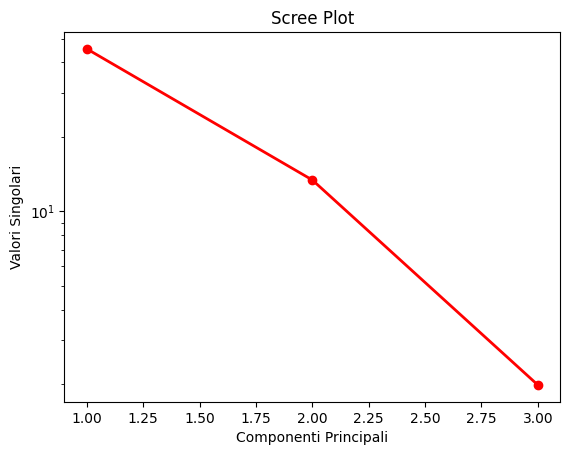




[45.38106549 13.38020282]
k scelto da guttman keiser:  3
[45.38106549 13.38020282  1.98222774]
k selezionato energia:  1
[45.38106549]
Valori singolari: 
[45.38106549 13.38020282  1.98222774]
rango:  3
Fj:  [0.91840928 0.07983848 0.00175224]
Entropia  0.26497129468979547
[ True  True  True]
Entropia = 0.26497129468979547  k selezionato = 1
[45.38106549]
Rango della matrice di Training: 3


RMSE Normali: 0.0116	 Tempo trascorso: 0.0030	Condizionamento: 524.1339
RMSE THIN QR: 0.0116	 Tempo trascorso: 0.0005	Condizionamento: 22.8940
RMSE THIN QR PIVOTING: 0.0116	 Tempo trascorso: 0.0005	Condizionamento: 22.8940
RMSE SVD SCREE-PLOT CATTEL: 0.0116	 Tempo trascorso: 0.0008	Condizionamento: 3.3917
RMSE SVD GUTTMAN KEISER: 0.0116	 Tempo trascorso: 0.0002	Condizionamento: 22.8940
RMSE SVD ENERGIA: 0.0510	 Tempo trascorso: 0.0001	Condizionamento: 1.0000
RMSE SVD ENTROPIA: 0.0510	 Tempo trascorso: 0.0008	Condizionamento: 1.0000

RMSE SWARM: 0.0294	 Tempo trascorso: 0.9828
RMSE SWARM RANDOM: 0.

In [28]:
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 2)
d = 2
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  3
permutazione:  [0 2 1 3]


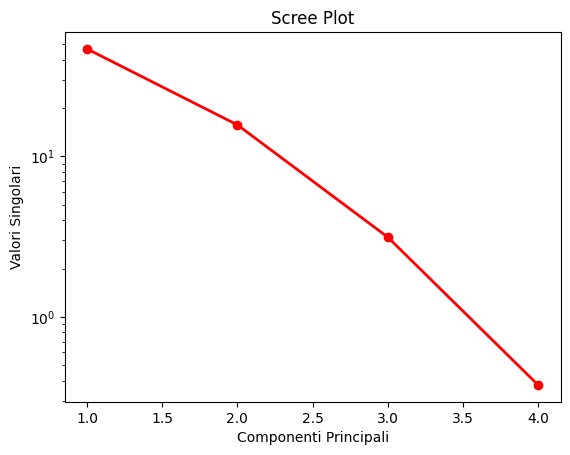




[46.84220613 15.73417275  3.14005508]
k scelto da guttman keiser:  3
[46.84220613 15.73417275  3.14005508]
k selezionato energia:  2
[46.84220613 15.73417275]
Valori singolari: 
[46.84220613 15.73417275  3.14005508  0.37580769]
rango:  4
Fj:  [8.94946644e-01 1.00974170e-01 4.02158262e-03 5.76041514e-05]
Entropia  0.25506819359830946
[ True  True  True  True]
Entropia = 0.25506819359830946  k selezionato = 1
[46.84220613]
Rango della matrice di Training: 4


RMSE Normali: 0.0118	 Tempo trascorso: 0.0006	Condizionamento: 15536.1484
RMSE THIN QR: 0.0118	 Tempo trascorso: 0.0017	Condizionamento: 124.6441
RMSE THIN QR PIVOTING: 0.0118	 Tempo trascorso: 0.0008	Condizionamento: 124.6441
RMSE SVD SCREE-PLOT CATTEL: 0.0116	 Tempo trascorso: 0.0006	Condizionamento: 14.9176
RMSE SVD GUTTMAN KEISER: 0.0116	 Tempo trascorso: 0.0002	Condizionamento: 14.9176
RMSE SVD ENERGIA: 0.0123	 Tempo trascorso: 0.0002	Condizionamento: 2.9771
RMSE SVD ENTROPIA: 0.0683	 Tempo trascorso: 0.0004	Condizionamento:

In [29]:
# SCELGO K = 3
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 3)
d = 3
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  3


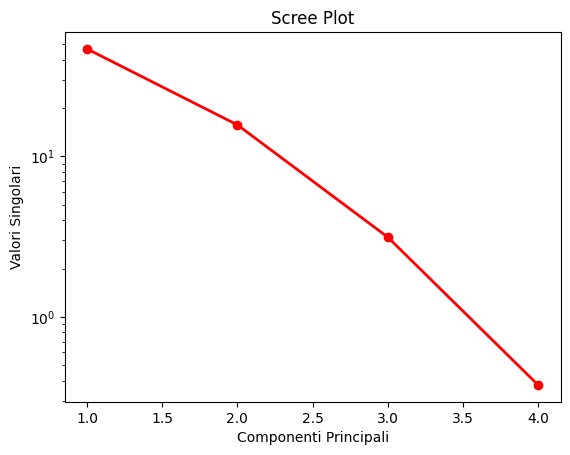




[46.84220613 15.73417275  3.14005508  0.37580769]
RMSE SVD SCREE-PLOT CATTEL: 0.0118	 Tempo trascorso: 0.0020	Condizionamento: 124.6441


In [30]:
# SCELGO K = 4
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 3)
d = 3
sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  4
permutazione:  [0 2 4 1 3]


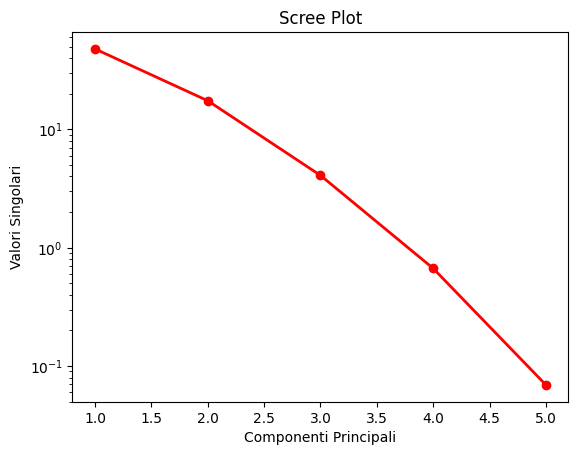




[47.87777501 17.47195173  4.08658299  0.66869153]
k scelto da guttman keiser:  3
[47.87777501 17.47195173  4.08658299]
k selezionato energia:  2
[47.87777501 17.47195173]
Valori singolari: 
[47.87777501 17.47195173  4.08658299  0.66869153  0.0692746 ]
rango:  5
Fj:  [8.76689145e-01 1.16750985e-01 6.38702118e-03 1.71013092e-04
 1.83537877e-06]
Entropia  0.24847589984591703
[ True  True  True  True  True]
Entropia = 0.24847589984591703  k selezionato = 2
[47.87777501 17.47195173]
Rango della matrice di Training: 5


RMSE Normali: 0.0127	 Tempo trascorso: 0.0005	Condizionamento: 477661.1552
RMSE THIN QR: 0.0127	 Tempo trascorso: 0.0004	Condizionamento: 691.1303
RMSE THIN QR PIVOTING: 0.0127	 Tempo trascorso: 0.0003	Condizionamento: 691.1303
RMSE SVD SCREE-PLOT CATTEL: 0.0120	 Tempo trascorso: 0.0012	Condizionamento: 71.5992
RMSE SVD GUTTMAN KEISER: 0.0116	 Tempo trascorso: 0.0003	Condizionamento: 11.7158
RMSE SVD ENERGIA: 0.0141	 Tempo trascorso: 0.0002	Condizionamento: 2.7403
RMSE SVD

In [31]:
# QUI SCELGO K = 4
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 4)
d = 4
stampa_modelli(trainData, testData, target, isNormalizzato, d)

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  4


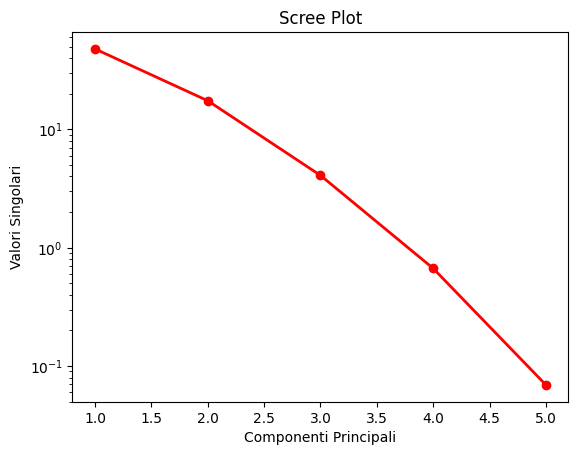




[47.87777501]
RMSE SVD SCREE-PLOT CATTEL: 0.0838	 Tempo trascorso: 0.0026	Condizionamento: 1.0000


In [32]:
# SCELGO K = 1
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 4)
d = 4
sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")

TARGET:  mean_pressure
Modello di regressione polinomiale, d =  4


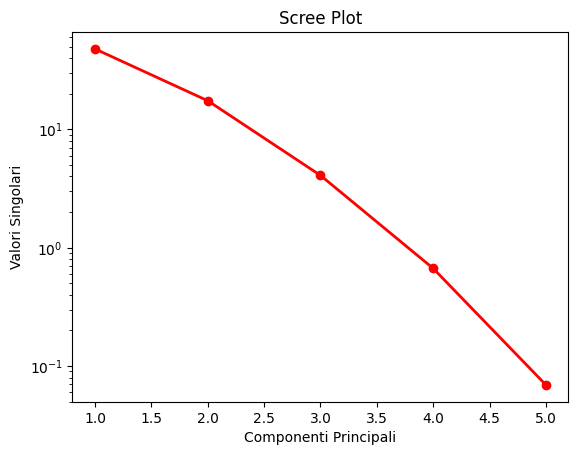




[47.87777501 17.47195173  4.08658299  0.66869153  0.0692746 ]
RMSE SVD SCREE-PLOT CATTEL: 0.0127	 Tempo trascorso: 0.0007	Condizionamento: 691.1303


In [33]:
# SCELGO K = 5
isNormalizzato = True
target = 'mean_pressure'
print("TARGET: ", target)
print("Modello di regressione polinomiale, d = ", 4)
d = 4
sc = Modello(trainData, testData, 'svd_scree_plot_cattel', target, isNormalizzato, d)
print(f"RMSE SVD SCREE-PLOT CATTEL: {sc.rmse:.4f}\t Tempo trascorso: {sc.tempo:.4f}\tCondizionamento: {sc.condizionamento:.4f}")

In [49]:
def calcola_tempo_medio_esecuzione(trainData, testData, metodo, target, isNormalizzato, d, maxit):
    tempo_totale = 0
    for i in range(maxit):
        x = Modello(trainData, testData, metodo, target, isNormalizzato, d)
        tempo_totale = tempo_totale + x.tempo
    return tempo_totale / maxit

In [50]:
def stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit):
            print("TEMPO MEDIO DI ESECUZIONE: \n")
            tempo_medio_normali = calcola_tempo_medio_esecuzione(trainData, testData, 'normali', target, isNormalizzato, d, maxit)
            tempo_medio_thin_qr = calcola_tempo_medio_esecuzione(trainData, testData, 'thin_qr', target, isNormalizzato, d, maxit)
            tempo_medio_qr_pivoting = calcola_tempo_medio_esecuzione(trainData, testData, 'thin_qr_pivoting', target, isNormalizzato, d, maxit)
            tempo_medio_guttman_keiser = calcola_tempo_medio_esecuzione(trainData, testData, 'svd_guttman_keiser', target, isNormalizzato, d, maxit)
            tempo_medio_energia = calcola_tempo_medio_esecuzione(trainData, testData, 'svd_energia', target, isNormalizzato, d, maxit)
            tempo_medio_entropia = calcola_tempo_medio_esecuzione(trainData, testData, 'svd_entropia', target, isNormalizzato, d, maxit)
            tempo_medio_swarm = calcola_tempo_medio_esecuzione(trainData, testData, 'swarm', target, isNormalizzato, d, maxit)
            tempo_medio_swarm_rand = calcola_tempo_medio_esecuzione(trainData, testData, 'swarm_rand', target, isNormalizzato, d, maxit)
            tempo_medio_swarm_d_lineare = calcola_tempo_medio_esecuzione(trainData, testData, 'swarm_d_lineare', target, isNormalizzato, d, maxit)
            tempo_medio_swarm_d_non_lineare = calcola_tempo_medio_esecuzione(trainData, testData, 'swarm_d_non_lineare', target, isNormalizzato, d, maxit)


            print("NORMALI: ", tempo_medio_normali)
            print("THIN QR: ", tempo_medio_thin_qr)
            print("THIN QR PIVOTING: ", tempo_medio_qr_pivoting)
            print("GUTTMAN KEISER: ", tempo_medio_guttman_keiser)
            print("ENERGIA: ", tempo_medio_energia)
            print("ENTROPIA: ", tempo_medio_entropia)
            print("SWARM: ", tempo_medio_swarm)
            print("SWARM RANDOM: ", tempo_medio_swarm_rand)
            print("SWARM DECREMENTO LINEARE: ", tempo_medio_swarm_d_lineare)
            print("SWARM DECREMENTO NON LINEARE: ", tempo_medio_swarm_d_non_lineare)

In [51]:
target = 'mean_pressure'
d = 1
isNormalizzato = False
maxit = 100

print("TARGET: ", target)
print("DATI NON NORMALIZZATI\n")
print("Modello di regressione lineare\n")
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

TARGET:  mean_pressure
DATI NON NORMALIZZATI

Modello di regressione lineare

TEMPO MEDIO DI ESECUZIONE: 

NORMALI:  0.00022244930267333984
THIN QR:  0.0002758336067199707
THIN QR PIVOTING:  0.0002932167053222656
GUTTMAN KEISER:  0.00013365507125854493
ENERGIA:  8.582830429077149e-05
ENTROPIA:  0.0001683664321899414
SWARM:  0.9394999241828919
SWARM RANDOM:  0.7332447934150695
SWARM DECREMENTO LINEARE:  0.6675184035301208
SWARM DECREMENTO NON LINEARE:  0.7998609256744384


In [52]:
d = 2
print("Modello di regressione polinomiale, d = ", d)
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

Modello di regressione polinomiale, d =  2
TEMPO MEDIO DI ESECUZIONE: 

NORMALI:  0.0002080655097961426
THIN QR:  0.00022372007369995118
THIN QR PIVOTING:  0.000420069694519043
GUTTMAN KEISER:  0.00013665199279785155
ENERGIA:  0.0002137279510498047
ENTROPIA:  0.00024462223052978515
SWARM:  0.9915478324890137
SWARM RANDOM:  0.9861125564575195
SWARM DECREMENTO LINEARE:  0.9845606994628906
SWARM DECREMENTO NON LINEARE:  0.8973605895042419


In [53]:
d = 3
print("Modello di regressione polinomiale, d = ", d)
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

Modello di regressione polinomiale, d =  3
TEMPO MEDIO DI ESECUZIONE: 



/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.42032e-20): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.42032e-20): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.42032e-20): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.42032e-20): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.42032e-20): result may not be accur

NORMALI:  0.0005587148666381836
THIN QR:  0.00031103134155273436
THIN QR PIVOTING:  0.00036451816558837893
GUTTMAN KEISER:  0.00011728286743164063
ENERGIA:  5.169868469238281e-05
ENTROPIA:  0.00020556926727294923
SWARM:  1.0108193397521972
SWARM RANDOM:  1.0117984843254089
SWARM DECREMENTO LINEARE:  1.0159240937232972
SWARM DECREMENTO NON LINEARE:  0.9341431903839111


In [54]:
d = 4
print("Modello di regressione polinomiale, d = ", d)
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

Modello di regressione polinomiale, d =  4
TEMPO MEDIO DI ESECUZIONE: 



/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69015e-26): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69015e-26): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69015e-26): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69015e-26): result may not be accurate.
  soluzioni = las.solve(ATA, (A.T @ b))
/var/folders/81/54fv74bj2d5_6s7bxrxxsz280000gn/T/ipykernel_87982/1209688551.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69015e-26): result may not be accur

NORMALI:  0.0002913331985473633
THIN QR:  0.00030081748962402344
THIN QR PIVOTING:  0.0002650570869445801
GUTTMAN KEISER:  0.00023622751235961913
ENERGIA:  9.023666381835938e-05
ENTROPIA:  0.00022812604904174806
SWARM:  1.0298770546913147
SWARM RANDOM:  1.0471986746788025
SWARM DECREMENTO LINEARE:  1.0252269315719604
SWARM DECREMENTO NON LINEARE:  0.9463991641998291


In [55]:
isNormalizzato = True
d = 1
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

TEMPO MEDIO DI ESECUZIONE: 

NORMALI:  0.00023000478744506837
THIN QR:  0.00027829647064208984
THIN QR PIVOTING:  0.0003822445869445801
GUTTMAN KEISER:  0.00010416030883789062
ENERGIA:  4.4178962707519534e-05
ENTROPIA:  0.0002577614784240723
SWARM:  0.9779004335403443
SWARM RANDOM:  0.7614712238311767
SWARM DECREMENTO LINEARE:  0.7517846250534057
SWARM DECREMENTO NON LINEARE:  0.8431868982315064


In [56]:
d = 2
print("Modello di regressione polinomiale, d = ", d)
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

Modello di regressione polinomiale, d =  2
TEMPO MEDIO DI ESECUZIONE: 

NORMALI:  0.00015449047088623047
THIN QR:  0.0002205204963684082
THIN QR PIVOTING:  0.00027153491973876955
GUTTMAN KEISER:  0.0001061701774597168
ENERGIA:  4.930257797241211e-05
ENTROPIA:  0.00013880252838134764
SWARM:  0.9922389554977417
SWARM RANDOM:  0.9602433848381042
SWARM DECREMENTO LINEARE:  0.8531996178627014
SWARM DECREMENTO NON LINEARE:  0.858411259651184


In [57]:
d = 3
print("Modello di regressione polinomiale, d = ", d)
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

Modello di regressione polinomiale, d =  3
TEMPO MEDIO DI ESECUZIONE: 

NORMALI:  0.00019744396209716797
THIN QR:  0.00024296760559082032
THIN QR PIVOTING:  0.0002596640586853027
GUTTMAN KEISER:  0.00014165639877319335
ENERGIA:  8.858203887939454e-05
ENTROPIA:  0.00018374443054199218
SWARM:  0.9803908753395081
SWARM RANDOM:  1.0175769996643067
SWARM DECREMENTO LINEARE:  0.9054229998588562
SWARM DECREMENTO NON LINEARE:  0.8882390236854554


In [58]:
d = 4
print("Modello di regressione polinomiale, d = ", d)
stampa_tempo_medio_esecuzione(trainData, testData, target, isNormalizzato, d, maxit)

Modello di regressione polinomiale, d =  4
TEMPO MEDIO DI ESECUZIONE: 

NORMALI:  0.00027146577835083005
THIN QR:  0.0004105353355407715
THIN QR PIVOTING:  0.0003055000305175781
GUTTMAN KEISER:  9.667396545410157e-05
ENERGIA:  9.053230285644532e-05
ENTROPIA:  0.00023439884185791015
SWARM:  1.0359749388694763
SWARM RANDOM:  1.0207976055145265
SWARM DECREMENTO LINEARE:  1.146274209022522
SWARM DECREMENTO NON LINEARE:  1.1539128613471985
